## Sagehen example with UZF, SFR, and MVR advanced packages activated

This script reproduces example 1 in the UZF1 Techniques and Methods
(Niswonger et al., 2006).

### MODFLOW 6 Sagehen Problem Setup

Append to system path to include the common subdirectory

In [1]:
import os
import sys

In [2]:
sys.path.append(os.path.join("..", "common"))
import sfr_uzf_mvr_support_funcs as sageBld

Imports

In [3]:
import flopy
import numpy as np
import pandas as pd
import config
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from figspecs import USGSFigure

In [4]:
sys.path.append(os.path.join("..", "data", "ex-gwf-sagehen"))
import sfr_static as sfrDat

In [5]:
mf6exe = os.path.abspath(config.mf6_exe)
exe_name_mf = config.mf2005_exe
exe_name_mt = config.mt3dms_exe

Set figure properties specific to this problem

In [6]:
figure_size = (6, 6)
figure_size_ts = (6, 3)

Base simulation and model name and workspace

In [7]:
ws = config.base_ws
example_name = "ex-gwf-sagehen"

Model units

In [8]:
length_units = "meters"
time_units = "days"

Table Sagehen Model Parameters

In [9]:
nlay = 1  # Number of layers in parent model
nrow = 73  # Number of rows in parent model
ncol = 81  # Number of columns in parent model
delr = 90.0  # Parent model column width ($m$)
delc = 90.0  # Parent model row width ($m$)
k11 = "0.005 - 0.3"  # Horizontal hydraulic conductivity ($m/d$)
k33 = "0.01 - 0.3"  # Vertical hydraulic conductivity ($m/d$)
sydum = "0.1 - 0.2"  # Specific Yield
dum1 = "0.15 - 0.25"  # Saturated water content
dum2 = 0.10  # Extinction water content
dum3 = "0.005 - 0.3"  # Saturated hydraulic conductivity of unsaturated zone
eps = 4.0  # Brooks-Corey Epsilon
sfrdum1 = 213  # Number of SFR stream reaches
sfrdum2 = 0.3  # Hydraulic conductivity of streambed ($m/d$)
sfrdum3 = 3  # Width of stream reaches ($m$)
sfrdum4 = 1  # Streambed thickness ($m$)

Additional model input preparation

In [10]:
# Time related variables
num_ts = 399
perlen = [1] * num_ts
nper = len(perlen)
nstp = [1] * num_ts
tsmult = [1.0] * num_ts

In [11]:
# from mf-nwt .dis file
dat_pth = os.path.join(config.data_ws, example_name)
top = np.loadtxt(os.path.join(dat_pth, "top1.txt"))
bot1 = np.loadtxt(os.path.join(dat_pth, "bot1.txt"))
# from mf-nwt .bas file
idomain1 = np.loadtxt(os.path.join(dat_pth, "ibnd1.txt"))
strt = np.loadtxt(os.path.join(dat_pth, "strt1.txt"))
# peel out locations of negative values for setting constant head data
tmp1 = np.where(idomain1 < 0)
listOfChdCoords = list(zip(np.zeros_like(tmp1[0]), tmp1[0], tmp1[1]))
# get the corresponding constant head values
if len(listOfChdCoords) > 0:
    chd_lay1 = list(np.take(strt, np.ravel_multi_index(tmp1, strt.shape)))
chdspd = []
for i in np.arange(len(listOfChdCoords)):
    chdspd.append([listOfChdCoords[i], chd_lay1[i]])
# finally, get rid of the negative values in idomain since mf6 treats
# negatives like zeros
idomain = np.abs(idomain1)

In [12]:
# from mf-nwt .upw file
k11 = np.loadtxt(os.path.join(dat_pth, "kh1.txt"))
sy = np.loadtxt(os.path.join(dat_pth, "sy1.txt"))
k33 = np.loadtxt(os.path.join(dat_pth, "kv1.txt"))
icelltype = 1  # Water table resides in layer 1
iconvert = np.ones_like(strt)

Solver settings

In [13]:
nouter, ninner = 300, 500
hclose, rclose, relax = 3e-2, 3e-2, 0.97

#### Prepping input for SFR package
Get package_data information

In [14]:
segs = sfrDat.get_sfrsegs()
rchs = sfrDat.get_sfrrchs()
sfrcells = sfrDat.get_sfrcells()
rlen = sfrDat.get_sfrlen()
rgrd = sfrDat.get_rgrd()
rtp = sfrDat.get_rtp()

In [15]:
# Define the connections
conns = sageBld.gen_mf6_sfr_connections(segs, rchs)

In [16]:
rwid = 3.0
rbth = 1.0
rhk = 0.6
man = 0.04
ustrf = 1.0
ndv = 0
pkdat = []
for i in np.arange(len(rlen)):
    ncon = len(conns[i]) - 1
    pkdat.append(
        (
            i,
            sfrcells[i],
            rlen[i],
            rwid,
            rgrd[i],
            rtp[i],
            rbth,
            rhk,
            man,
            ncon,
            ustrf,
            ndv,
        )
    )

#### Prepping input for DRN package

In [17]:
# Instantiating MODFLOW 6 drain package
# Here, the drain (DRN) package is used to simulate groundwater discharge to
# land surface to keep this water separate from rejected infiltrated simulated
# by the UZF package. Need to cycle through all land surface cells and create a
# drain for handling groundwater discharge to land surface
drn_spd = []
drn_dict = {}
drn_dict_rev = {}
# Use an arbitrarily high conductance term to avoid impeding groundwater disch.
cond = 10000
# See definition of auxdepthname in DRN package doc to learn more about param
ddrn = -0.25
idrnno = 0
for i in np.arange(0, top.shape[0]):
    for j in np.arange(0, top.shape[1]):
        # Don't add drains to sfr and chd cells:
        sfrCell_bool = (
            1
            if len([itm for itm in sfrcells if itm[1] == i and itm[2] == j])
            > 0
            else 0
        )
        chdCell_bool = (
            1
            if len(
                [itm for itm in listOfChdCoords if itm[1] == i and itm[2] == j]
            )
            > 0
            else 0
        )
        if idomain1[i, j] and not sfrCell_bool and not chdCell_bool:
            drn_spd.append([(0, i, j), top[i, j], cond, ddrn])  #  'ddrn',
            # append dictionary of drain indices
            drn_dict.update({(i, j): idrnno})
            drn_dict_rev.update({idrnno: (i, j)})
            idrnno += 1

#### Prepping input for UZF package
Package_data information

In [18]:
iuzbnd = np.loadtxt(os.path.join(dat_pth, "iuzbnd.txt"))
thts = np.loadtxt(os.path.join(dat_pth, "thts.txt"))
uzk33 = np.loadtxt(os.path.join(dat_pth, "vks.txt"))
finf_grad = np.loadtxt(os.path.join(dat_pth, "finf_gradient.txt"))
# next, load time series of multipliers
uz_ts = pd.read_csv(
    os.path.join(dat_pth, "uzf_ts.dat"), delim_whitespace=True, header=0
)

In [19]:
# Need to set iuzbnd inactive where there are constant head cells, or where the
# model grid is inactive
cells2inactivate = idomain1 - iuzbnd
iuzbnd = iuzbnd + cells2inactivate
for chd_cell in listOfChdCoords:
    iuzbnd[chd_cell[1], chd_cell[2]] = 0

In [20]:
ha = 0.0
hroot = 0.0
rootact = 0.0

In [21]:
uzf_packagedata = []
pd0 = []
iuzno_cell_dict = {}
iuzno_dict_rev = {}
iuzno = 0
surfdep = 0.1
# Set up the UZF static variables
nuzfcells = 0
for k in range(nlay):
    for i in range(0, iuzbnd.shape[0] - 1):
        for j in range(0, iuzbnd.shape[1] - 1):
            if iuzbnd[i, j] != 0:
                nuzfcells += 1
                if k == 0:
                    lflag = 1
                    # establish new dictionary entry for current cell
                    # addresses & iuzno connections are both 0-based
                    iuzno_cell_dict.update({(i, j): iuzno})
                    # For post-processing the mvr output, need reverse dict
                    iuzno_dict_rev.update({iuzno: (i, j)})
                else:
                    lflag = 0

                # Set the vertical connection, which is the cell below,
                # but in this 1 layer model set to -1 which flopy adjusts to 0
                ivertcon = -1

                vks = uzk33[i, j]
                thtr = uz_ts["extwc"].iloc[0]
                thtsx = thts[i, j]
                thti = thtr + 0.01
                eps = 4.0

                # Set the boundname for the land surface cells
                bndnm = "sage"

                uz = [
                    iuzno,
                    (k, i, j),
                    lflag,
                    ivertcon,
                    surfdep,
                    vks,
                    thtr,
                    thtsx,
                    thti,
                    eps,
                    bndnm,
                ]
                uzf_packagedata.append(uz)

                iuzno += 1

In [22]:
# Next prepare the stress period data for UZF
# Store the steady state uzf stresses in dictionary
uzf_perioddata = {}
for t in range(num_ts):
    iuzno = 0
    spdx = []
    for i in range(0, iuzbnd.shape[0] - 1):
        for j in range(0, iuzbnd.shape[1] - 1):
            if iuzbnd[i, j] != 0:
                finf = finf_grad[i, j] * uz_ts["finf"].iloc[t]
                pet = uz_ts["pet"].iloc[t]
                extdp = uz_ts["rootdepth"].iloc[t]
                extwc = uz_ts["extwc"].iloc[t]
                spdx.append(
                    [iuzno, finf, pet, extdp, extwc, ha, hroot, rootact]
                )
                iuzno += 1
    uzf_perioddata.update({t: spdx})

In [23]:
# Set up runoff connections, which relies on a helper function inside a
# companion script
#
# Leverages a function that uses the top elevation array and SFR locations to
# calculate an array that is the equivalent of the irunbnd array from the UZF1
# package.  The MVR package will be used to establish these connection in MF6
# since the IRUNBND functionality went away in the new MF6 framework.
irunbnd = sageBld.determine_runoff_conns_4mvr(
    dat_pth, top, idomain1, rchs, nrow, ncol
)

In [24]:
iuzno = 0
k = 0  # Hard-wire the layer no.
first0ok = True
static_mvrperioddata = []
for i in range(0, iuzbnd.shape[0]):
    for j in range(0, iuzbnd.shape[1]):
        if irunbnd[i, j] > 0:  # This is a uzf -> sfr connection
            iuzno = iuzno_cell_dict.get((i, j))
            if iuzno or first0ok:
                static_mvrperioddata.append(
                    ("UZF-1", iuzno, "SFR-1", irunbnd[i, j] - 1, "FACTOR", 1.0)
                )

        drn_idx = drn_dict.get((i, j))
        if drn_idx:
            static_mvrperioddata.append(
                ("DRN-1", drn_idx, "SFR-1", irunbnd[i, j] - 1, "FACTOR", 1.0)
            )
            first0ok = False

In [25]:
mvrspd = {0: static_mvrperioddata}
mvrpack = [["UZF-1"], ["SFR-1"], ["DRN-1"]]
maxpackages = len(mvrpack)
maxmvr = 10000  # Something arbitrarily high

### Function to build models

MODFLOW 6 flopy simulation object (sim) is returned if building the model

In [26]:
def build_model(sim_name, silent=False):
    if config.buildModel:

        # Instantiate the MODFLOW 6 simulation
        sim_ws = os.path.join(ws, example_name)
        sim = flopy.mf6.MFSimulation(
            sim_name=example_name,
            version="mf6",
            sim_ws=sim_ws,
            exe_name=mf6exe,
        )

        # Instantiating MODFLOW 6 time discretization
        tdis_rc = []
        for i in range(len(perlen)):
            tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
        flopy.mf6.ModflowTdis(
            sim, nper=nper, perioddata=tdis_rc, time_units=time_units
        )

        # Instantiating MODFLOW 6 groundwater flow model
        gwfname = example_name
        gwf = flopy.mf6.ModflowGwf(
            sim,
            modelname=gwfname,
            save_flows=True,
            newtonoptions="newton",
            model_nam_file="{}.nam".format(gwfname),
        )

        # Instantiating MODFLOW 6 solver for flow model
        imsgwf = flopy.mf6.ModflowIms(
            sim,
            print_option="summary",
            outer_dvclose=hclose,
            outer_maximum=nouter,
            under_relaxation="dbd",
            linear_acceleration="BICGSTAB",
            under_relaxation_theta=0.7,
            under_relaxation_kappa=0.08,
            under_relaxation_gamma=0.05,
            under_relaxation_momentum=0.0,
            inner_dvclose=hclose,
            rcloserecord="1000.0 strict",
            inner_maximum=ninner,
            relaxation_factor=relax,
            number_orthogonalizations=2,
            preconditioner_levels=8,
            preconditioner_drop_tolerance=0.001,
            filename="{}.ims".format(gwfname),
        )
        sim.register_ims_package(imsgwf, [gwf.name])

        # Instantiating MODFLOW 6 discretization package
        flopy.mf6.ModflowGwfdis(
            gwf,
            nlay=nlay,
            nrow=nrow,
            ncol=ncol,
            delr=delr,
            delc=delc,
            top=top,
            botm=bot1,
            idomain=idomain,
            filename="{}.dis".format(gwfname),
        )

        # Instantiating MODFLOW 6 initial conditions package for flow model
        flopy.mf6.ModflowGwfic(
            gwf, strt=strt, filename="{}.ic".format(gwfname)
        )

        # Instantiating MODFLOW 6 node-property flow package
        flopy.mf6.ModflowGwfnpf(
            gwf,
            save_flows=False,
            alternative_cell_averaging="AMT-HMK",
            icelltype=icelltype,
            k=k11,
            k33=k33,
            save_specific_discharge=False,
            filename="{}.npf".format(gwfname),
        )

        # Instantiate MODFLOW 6 storage package
        flopy.mf6.ModflowGwfsto(
            gwf,
            ss=2e-6,
            sy=sy,
            iconvert=iconvert,
            steady_state={0: True},
            transient={1: True},
            filename="{}.sto".format(gwfname),
        )

        # Instantiating MODFLOW 6 output control package for flow model
        flopy.mf6.ModflowGwfoc(
            gwf,
            budget_filerecord="{}.bud".format(gwfname),
            head_filerecord="{}.hds".format(gwfname),
            headprintrecord=[
                ("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")
            ],
            saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
            printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
        )

        # Instantiating MODFLOW 6 constant head package
        chdspdx = {0: chdspd}
        flopy.mf6.ModflowGwfchd(
            gwf,
            maxbound=len(chdspd),
            stress_period_data=chdspdx,
            save_flows=False,
            pname="CHD-1",
            filename="{}.chd".format(gwfname),
        )

        maxbound = len(drn_spd)  # The total number
        spd = {0: drn_spd}
        flopy.mf6.ModflowGwfdrn(
            gwf,
            pname="DRN-1",
            auxiliary=["ddrn"],
            auxdepthname="ddrn",
            print_input=False,
            print_flows=False,
            maxbound=maxbound,
            mover=True,
            stress_period_data=spd,  # wel_spd established in the MVR setup
            boundnames=False,
            save_flows=True,
            filename="{}.drn".format(gwfname),
        )

        # Instantiating MODFLOW 6 streamflow routing package
        flopy.mf6.ModflowGwfsfr(
            gwf,
            print_stage=False,
            print_flows=False,
            budget_filerecord=gwfname + ".sfr.bud",
            save_flows=True,
            mover=True,
            pname="SFR-1",
            unit_conversion=86400.0,
            boundnames=True,
            nreaches=len(conns),
            packagedata=pkdat,
            connectiondata=conns,
            perioddata=None,
            filename="{}.sfr".format(gwfname),
        )

        # Instantiating MODFLOW 6 unsaturated zone flow package
        flopy.mf6.ModflowGwfuzf(
            gwf,
            nuzfcells=nuzfcells,
            boundnames=True,
            mover=True,
            ntrailwaves=15,
            nwavesets=150,
            print_flows=False,
            save_flows=True,
            simulate_et=True,
            linear_gwet=True,
            packagedata=uzf_packagedata,
            perioddata=uzf_perioddata,
            budget_filerecord="{}.uzf.bud".format(gwfname),
            pname="UZF-1",
            filename="{}.uzf".format(gwfname),
        )

        flopy.mf6.ModflowGwfmvr(
            gwf,
            pname="MVR-1",
            maxmvr=maxmvr,
            print_flows=False,
            maxpackages=maxpackages,
            packages=mvrpack,
            perioddata=mvrspd,
            budget_filerecord=gwfname + ".mvr.bud",
            filename="{}.mvr".format(gwfname),
        )

        return sim
    return None

Function to write model files

In [27]:
def write_model(sim, silent=True):
    if config.writeModel:
        sim.write_simulation(silent=silent)

Function to run the model. True is returned if the model runs successfully

In [28]:
@config.timeit
def run_model(sim, silent=True):
    success = True
    if config.runModel:
        success = False
        success, buff = sim.run_simulation(silent=silent)
        if not success:
            print(buff)
    return success

Function to plot the model results

In [29]:
def plot_results(mf6, idx):
    if config.plotModel:
        print("Plotting model results...")
        sim_name = mf6.name
        fs = USGSFigure(figure_type="graph", verbose=False)

        # Generate a plot of FINF distribution
        finf_plt = finf_grad.copy()
        finf_plt[idomain1 == 0] = np.nan

        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(finf_plt, cmap="jet")
        title = "Precipitation distribution"
        cbar = plt.colorbar(shrink=0.5)
        cbar.ax.set_title("Infiltration\nrate\nfactor", pad=20)
        plt.xlabel("Column Number")
        plt.ylabel("Row Number")
        fs.heading(heading=title)

        # save figure
        if config.plotSave:
            fpth = os.path.join(
                "..",
                "figures",
                "{}{}".format(sim_name + "-finfFact", config.figure_ext),
            )
            fig.savefig(fpth)

        # Start by retrieving some output
        gwf = mf6.get_model(list(mf6.model_names)[0])
        hdsobj = gwf.output.head()
        modobj = gwf.output.budget()
        sfrobj = gwf.sfr.output.budget()
        uzfobj = gwf.uzf.output.budget()

        ckstpkper = modobj.get_kstpkper()

        hds = []
        depths = []
        hd_tmp = hdsobj.get_data(kstpkper=ckstpkper[0])
        hd_tmp = np.where(hd_tmp == 1e30, 0, hd_tmp)
        hds.append(hd_tmp)
        depths.append(top - hd_tmp[0, :, :])
        depths = np.array(depths)
        depths = depths[0, :, :]

        # Generate a plot of the gw table depths for the steady state stress per
        depths[idomain1 == 0] = np.nan

        fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        plt.imshow(depths, vmin=0, vmax=25, cmap="jet")
        cbar = plt.colorbar(shrink=0.5, ticks=[0, 5, 10, 15, 20, 25])
        cbar.ax.set_yticklabels(["0", "5", "10", "15", "20", "> 25"])
        cbar.ax.set_title("Depth to\nwater\ntable,\nin m", pad=20)
        plt.xlabel("Column Number")
        plt.ylabel("Row Number")
        title = "Depth To Groundwater"
        fs.heading(heading=title)

        # save figure
        if config.plotSave:
            fpth = os.path.join(
                "..",
                "figures",
                "{}{}".format(sim_name + "-gwDepth", config.figure_ext),
            )
            fig.savefig(fpth)

        drn_disQ = []
        uzrech = []
        finf_tot = []
        sfr_gwsw = []
        sfr_flow = []
        rejinf = []
        uzet = []
        gwet = []
        outflow = []

        for kstpkper in ckstpkper:
            # 1. Compile groundwater discharge to land surface
            drn_tmp = modobj.get_data(
                kstpkper=kstpkper, text="      DRN-TO-MVR"
            )
            drn_arr = np.zeros_like(top)
            for itm in drn_tmp[0]:
                i, j = drn_dict_rev[itm[1] - 1]
                drn_arr[i, j] = itm[2]
            drn_disQ.append(drn_arr)

            # 2. Compile groundwater discharge to stream cells
            sfr_tmp = sfrobj.get_data(
                kstpkper=kstpkper, text="             GWF"
            )
            sfr_arr = np.zeros_like(top)
            for x, itm in enumerate(sfr_tmp[0]):
                i = sfrcells[x][1]
                j = sfrcells[x][2]
                sfr_arr[i, j] = itm[2]
            sfr_gwsw.append(sfr_arr)

            # 3. Compile Infiltrated amount
            uzf_tmp = uzfobj.get_data(
                kstpkper=kstpkper, text="    INFILTRATION"
            )
            finf_arr = np.zeros_like(top)
            for itm in uzf_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                finf_arr[i, j] = itm[2]
            finf_tot.append(finf_arr)

            # 4. Compile recharge from UZF
            uzrch_tmp = uzfobj.get_data(
                kstpkper=kstpkper, text="             GWF"
            )
            uzrch_arr = np.zeros_like(top)
            for itm in uzrch_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                uzrch_arr[i, j] = itm[2]
            uzrech.append(uzrch_arr)

            # 5. Compile rejected infiltration
            rejinf_tmp = uzfobj.get_data(
                kstpkper=kstpkper, text="  REJ-INF-TO-MVR"
            )
            rejinf_arr = np.zeros_like(top)
            for itm in rejinf_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                rejinf_arr[i, j] = itm[2]
            rejinf.append(rejinf_arr)

            # 6. Compile unsat ET
            uzet_tmp = uzfobj.get_data(
                kstpkper=kstpkper, text="            UZET"
            )
            uzet_arr = np.zeros_like(top)
            for itm in uzet_tmp[0]:
                i, j = iuzno_dict_rev[itm[0] - 1]
                uzet_arr[i, j] = itm[2]
            uzet.append(uzet_arr)

            # 7. Compile groundwater ET
            gwet_tmp = modobj.get_data(
                kstpkper=kstpkper, text="        UZF-GWET"
            )
            gwet_arr = np.zeros_like(top)
            for itm in gwet_tmp[0]:
                i, j = iuzno_dict_rev[itm[1] - 1]
                gwet_arr[i, j] = itm[2]
            gwet.append(gwet_arr)

            # 8. Get flows at outlet
            outletQ = sfrobj.get_data(
                kstpkper=kstpkper, text="    FLOW-JA-FACE"
            )
            outflow.append(outletQ[0][-1][2])

        drn_disQ = np.array(drn_disQ)
        sfr_gwsw = np.array(sfr_gwsw)
        finf_tot = np.array(finf_tot)
        uzrech = np.array(uzrech)
        rejinf = np.array(rejinf)
        uzet = np.array(uzet)
        gwet = np.array(gwet)
        outflow = np.array(outflow)

        drn_disQ_ts = drn_disQ.sum(axis=-1).sum(axis=-1)
        sfr_gwsw_ts = sfr_gwsw.sum(axis=-1).sum(axis=-1)
        finf_tot_ts = finf_tot.sum(axis=-1).sum(axis=-1)
        uzrech_ts = uzrech.sum(axis=-1).sum(axis=-1)
        rejinf_ts = rejinf.sum(axis=-1).sum(axis=-1)
        uzet_ts = uzet.sum(axis=-1).sum(axis=-1)
        gwet_ts = gwet.sum(axis=-1).sum(axis=-1)

        rng = pd.date_range(start="11/1/1999", end="10/31/2000", freq="D")
        data = {
            "Recharge": abs(uzrech_ts[0:366]),
            "Infiltration": abs(finf_tot_ts[0:366]),
            "GroundwaterET": abs(gwet_ts[0:366]),
            "UnsaturatedZoneET": abs(uzet_ts[0:366]),
        }
        vals1 = pd.DataFrame(data, index=rng)

        fig = plt.figure(figsize=figure_size_ts, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        vals1.Infiltration.plot(style="k-", linewidth=0.3)
        vals1.Recharge.plot(style="b-", linewidth=0.7)
        vals1.GroundwaterET.plot(
            style="-", color="darkgreen", linewidth=0.7, label="Groundwater ET"
        )
        vals1.UnsaturatedZoneET.plot(
            style="-", color="orange", linewidth=1, label="Unsaturated Zone ET"
        )
        ax.set_ylim(0, 700000)
        plt.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=True,
        )  # labels along the bottom edge are off
        ax.set_xlabel("Month")
        ax.set_ylabel("Volumetric Rate, $m^3$ per day")
        fs.graph_legend(ax)
        title = "Unsaturated Zone Flow Budget"
        fs.heading(heading=title)

        # save figure
        if config.plotSave:
            fpth = os.path.join(
                "..",
                "figures",
                "{}{}".format(sim_name + "-uzFlow", config.figure_ext),
            )
            fig.savefig(fpth)

        data_sfr = {
            "GroundwaterDischarge": abs(drn_disQ_ts[0:366]),
            "RejectedInfiltration": abs(rejinf_ts[0:366]),
            "gwswExchange": abs(sfr_gwsw_ts[0:366]),
            "outflow": outflow[0:366],
        }
        vals2 = pd.DataFrame(data_sfr, index=rng)

        fig = plt.figure(figsize=figure_size_ts, dpi=300, tight_layout=True)
        ax = fig.add_subplot(1, 1, 1)
        vals2.outflow.plot(
            style="-",
            linewidth=0.5,
            color="royalblue",
            label="Streamflow at Outlet",
        )
        vals2.GroundwaterDischarge.plot(
            style="k-", linewidth=0.7, label="Groundwater Discharge"
        )
        vals2.RejectedInfiltration.plot(
            style="-",
            linewidth=0.7,
            color="brown",
            label="Rejected Infiltration",
        )
        vals2.gwswExchange.plot(
            style="-",
            color="darkgreen",
            linewidth=0.7,
            label="GW Discharge to Streams",
        )
        ax.set_ylim(0, 350000)
        plt.tick_params(
            axis="x",  # changes apply to the x-axis
            which="both",  # both major and minor ticks are affected
            bottom=False,  # ticks along the bottom edge are off
            top=False,  # ticks along the top edge are off
            labelbottom=True,
        )  # labels along the bottom edge are off
        ax.set_xlabel("Month")
        ax.set_ylabel("Volumetric Rate, $m^3$ per day")
        fs.graph_legend(ax)
        title = "Surface Water Flow"
        fs.heading(heading=title)

        # save figure
        if config.plotSave:
            fpth = os.path.join(
                "..",
                "figures",
                "{}{}".format(sim_name + "-swFlow", config.figure_ext),
            )
            fig.savefig(fpth)

Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [30]:
def scenario(idx, silent=True):
    sim = build_model(example_name)
    write_model(sim, silent=silent)
    success = run_model(sim, silent=silent)

    if success:
        plot_results(sim, idx)

### Sagehen Model Results

Two-dimensional transport in a uniform flow field

run_model  94,135.46 ms
Plotting model results...


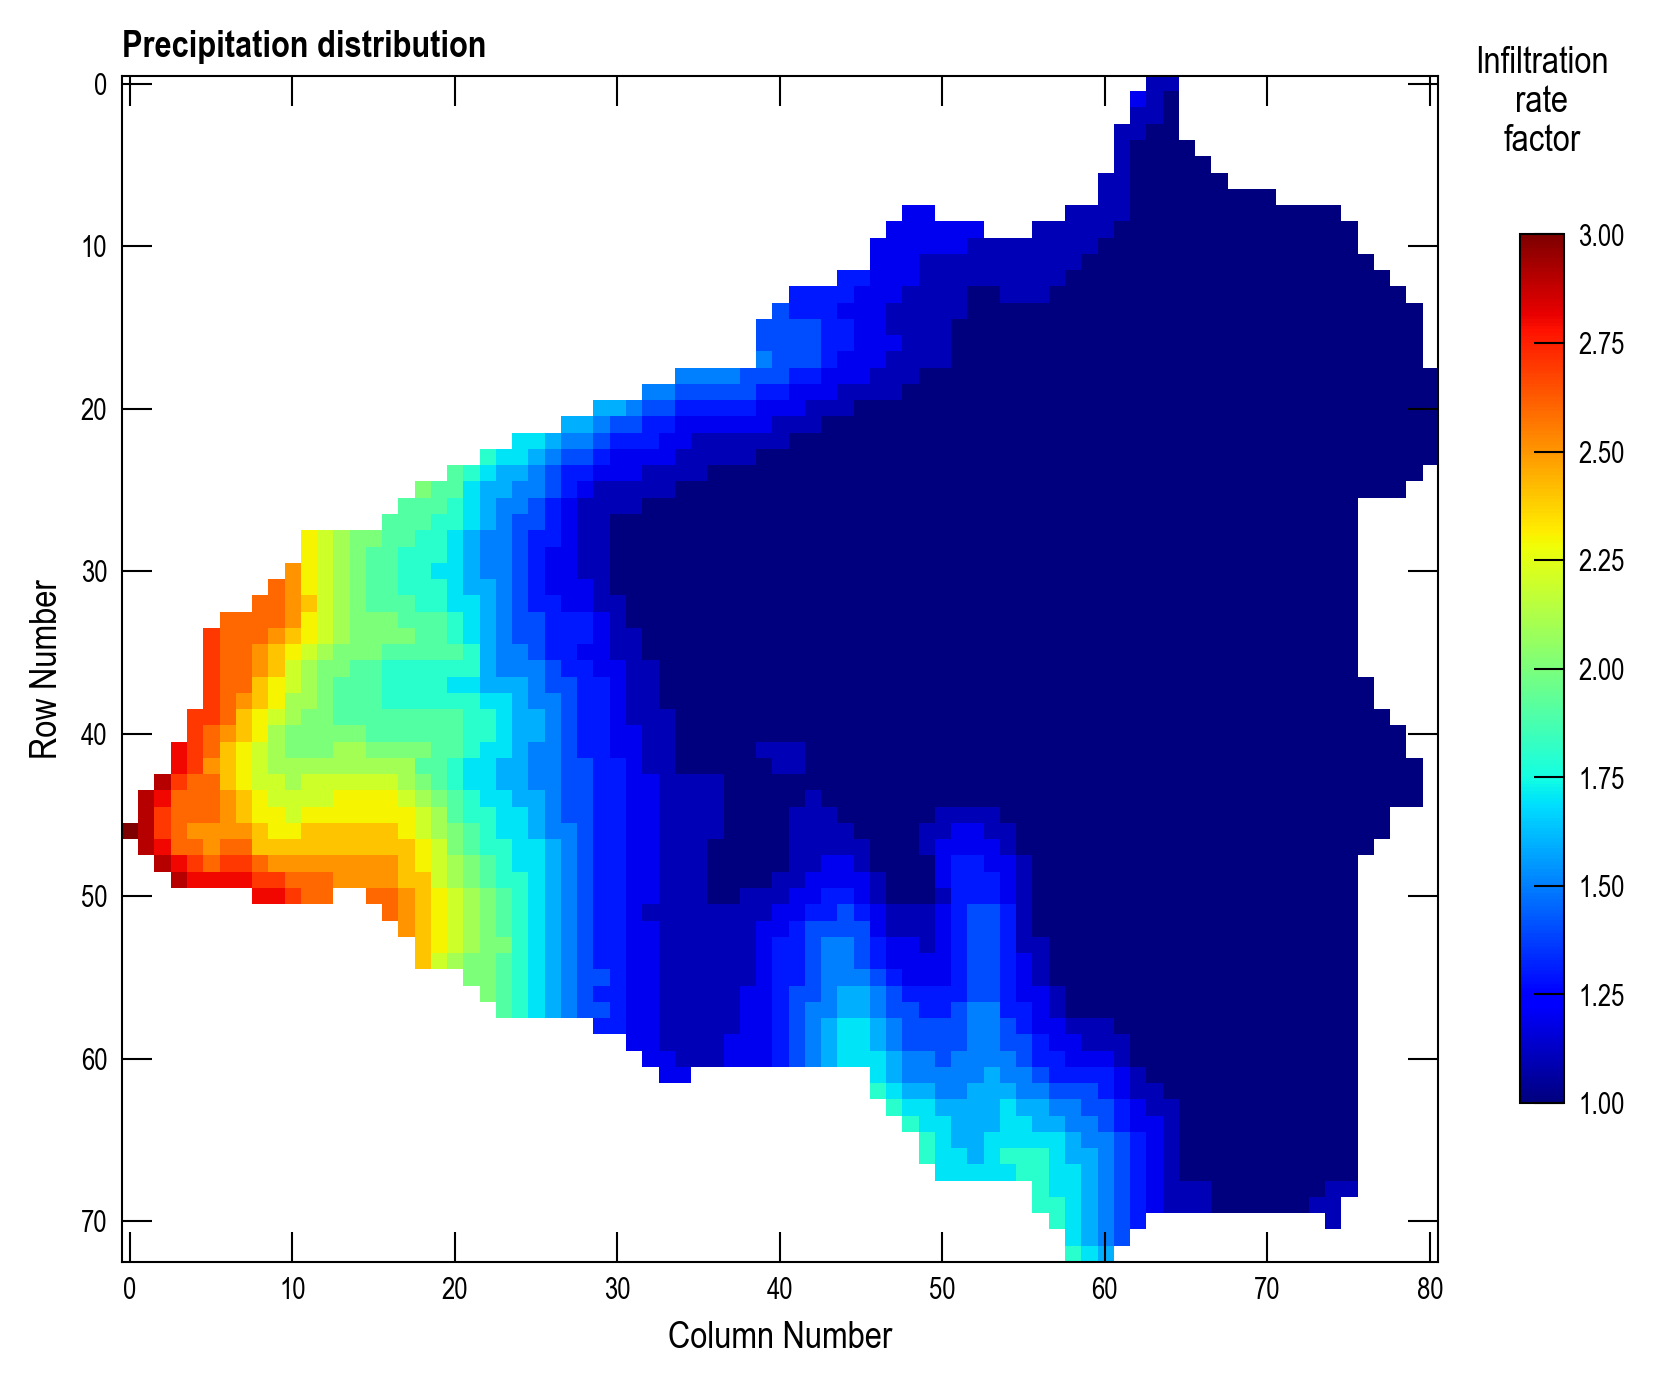

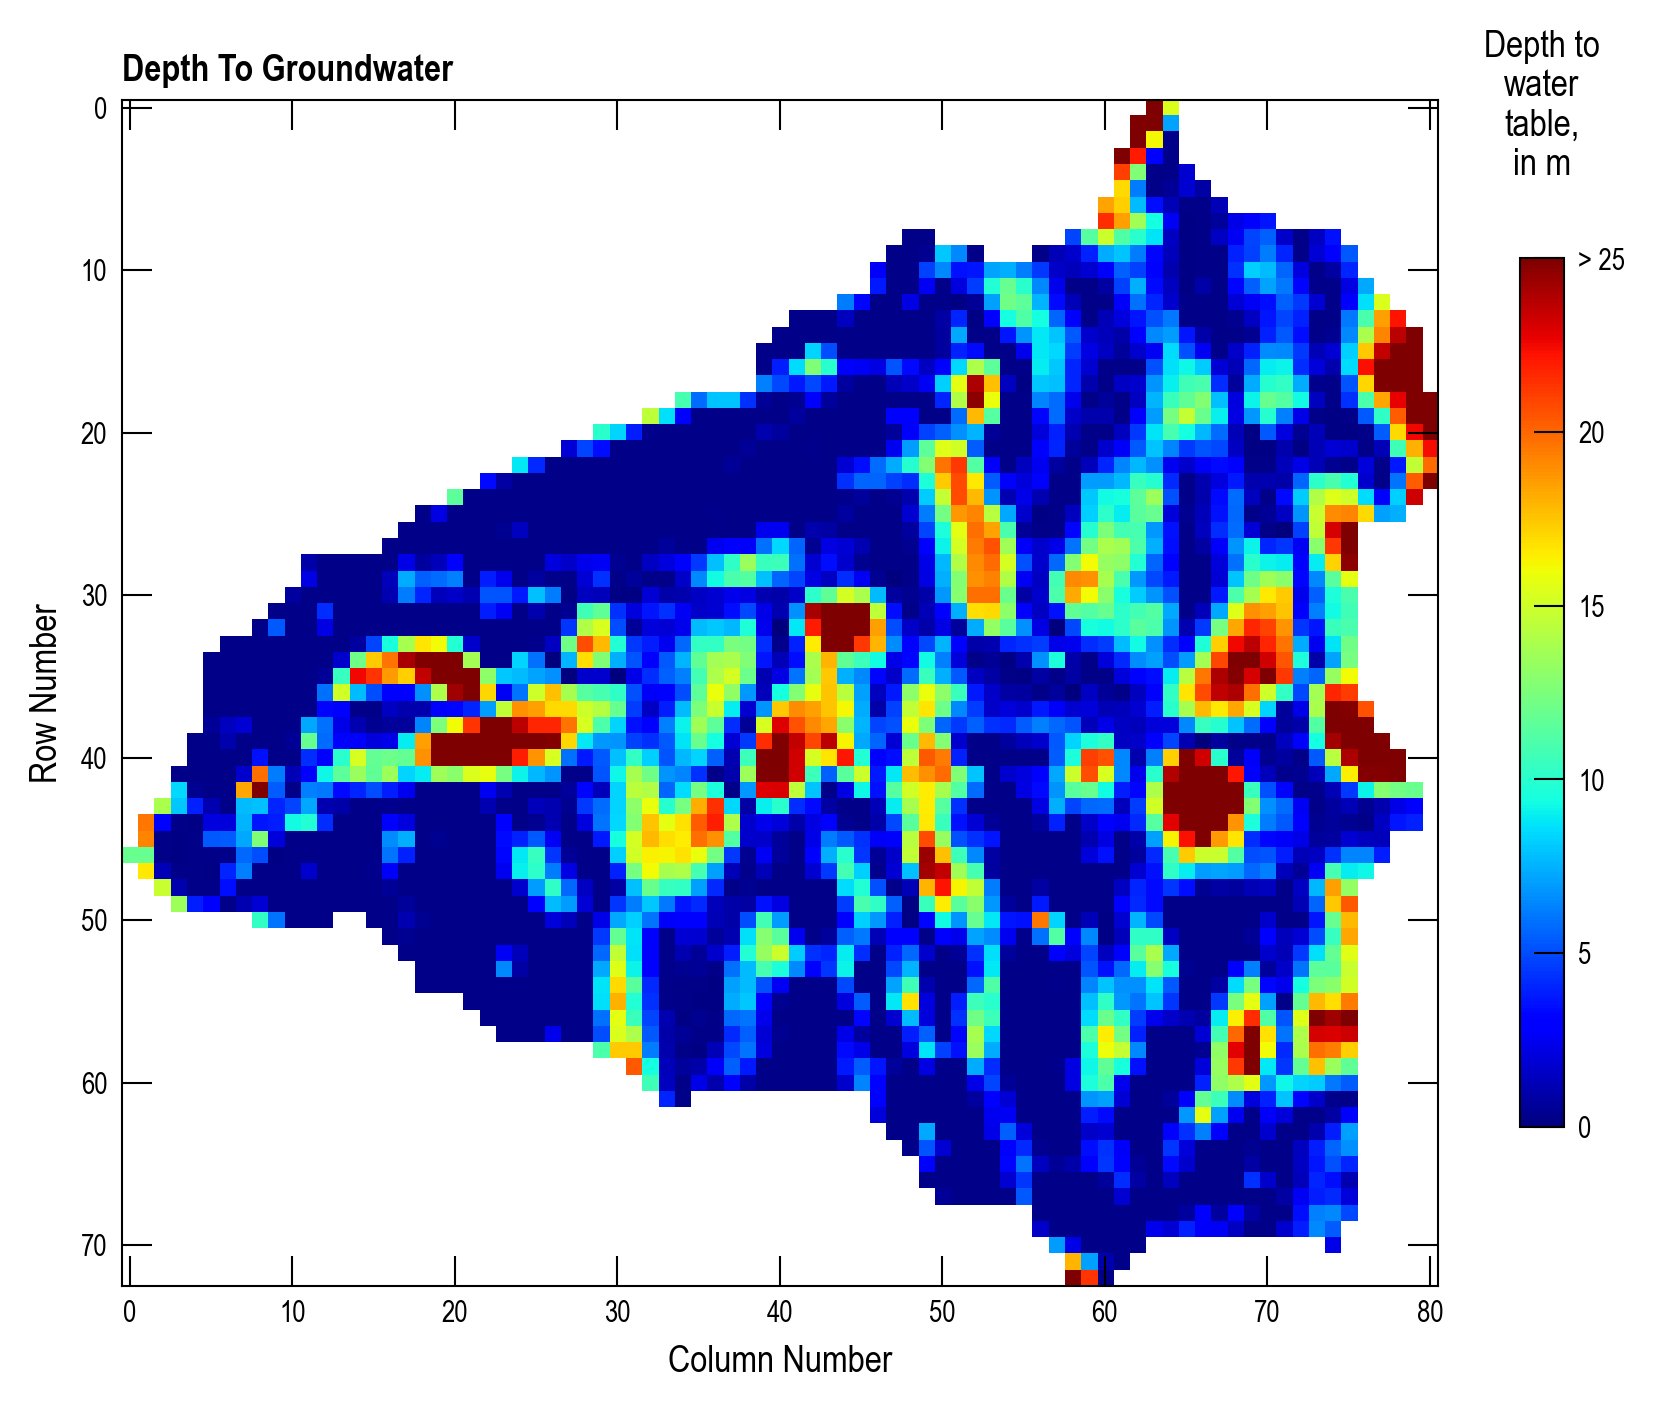

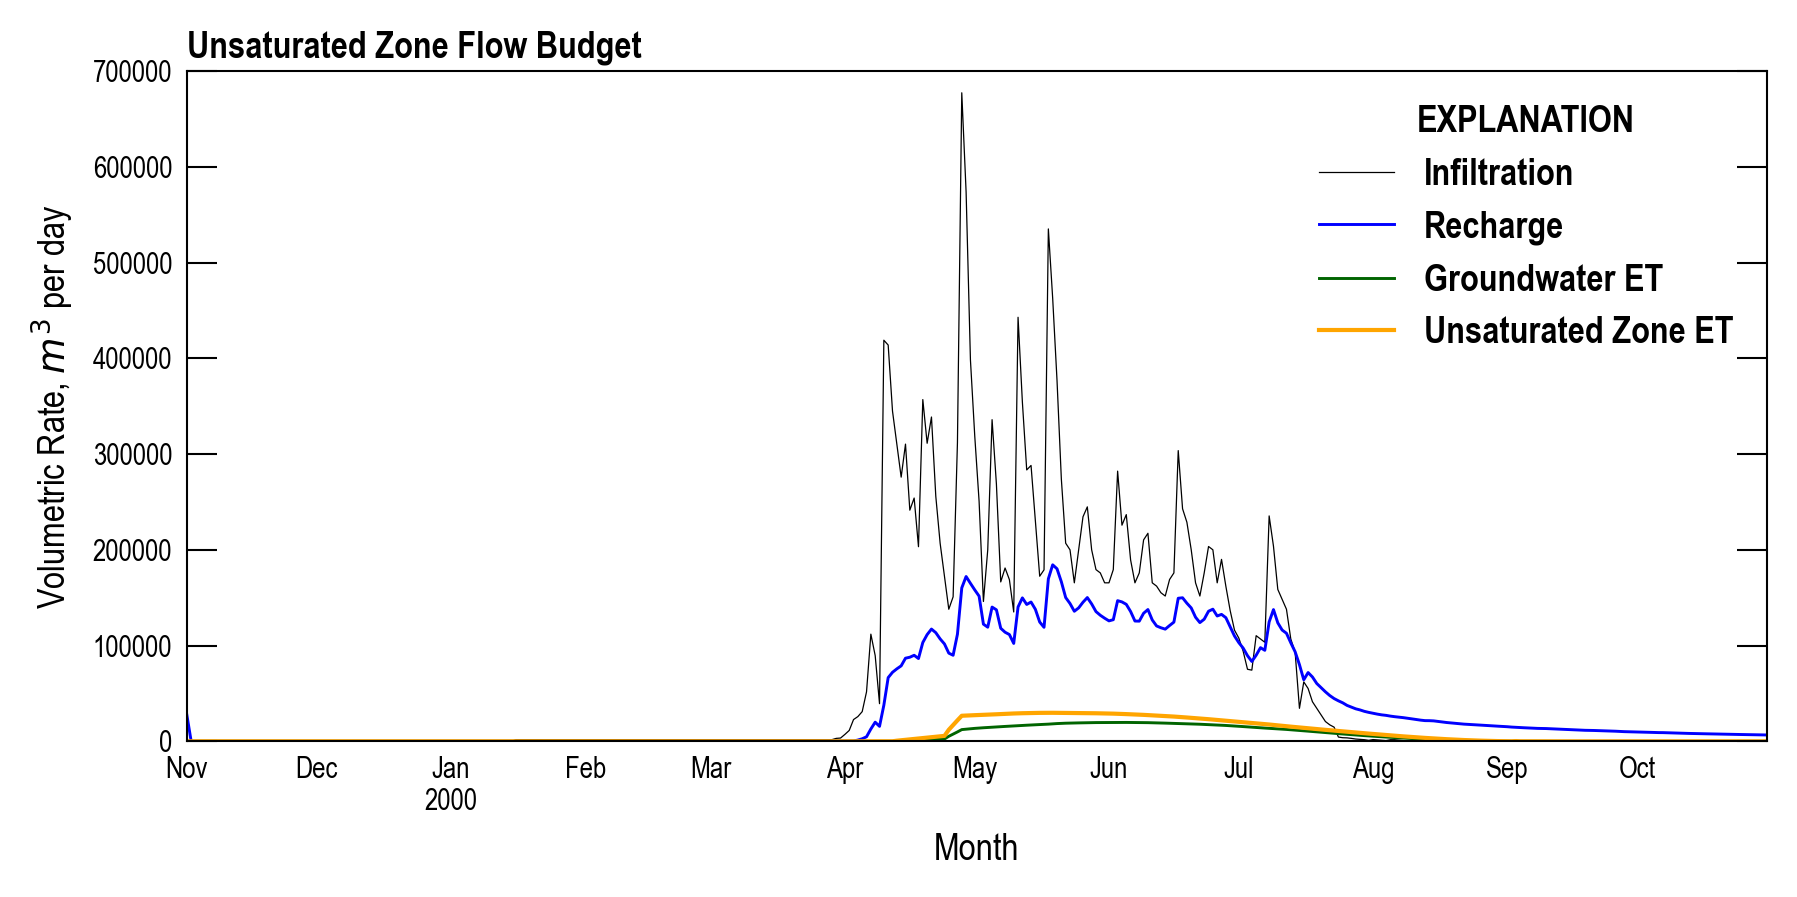

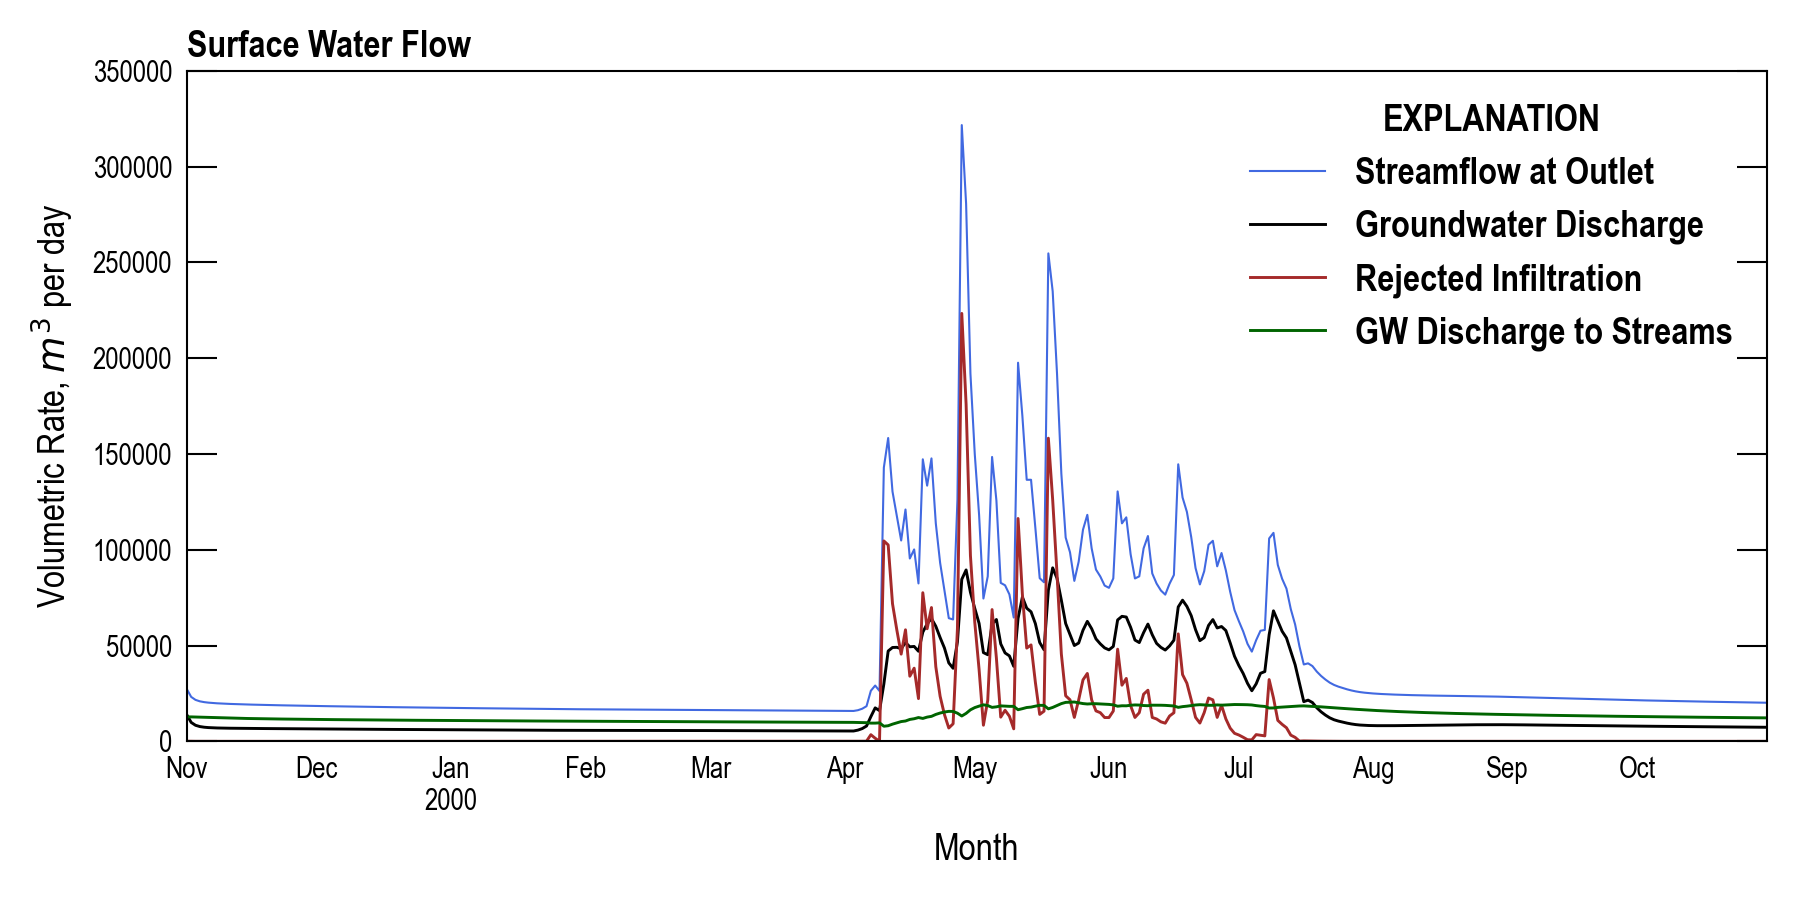

In [32]:
scenario(0)